In [1]:
import glob
import numpy as np
import gpflow
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd

In [2]:
tf.__version__

'2.6.0'

In [3]:
import MATSgp
import matplotlib.pyplot as plt

HAPI version: 1.1.1.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


2021-08-26 15:58:28.321956: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# set seed for reproducible results
np.random.seed(0)

# Read in raw spectral data

The next two cells identify and load in raw data in the form of csv files, skipping one header row.

In [5]:
dat_files = glob.glob('../Examples/A-Band - Experimental Spectra/*forfit.csv')
dat_files.sort()
dat_files

['../Examples/A-Band - Experimental Spectra/190510_2per_43_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190510_2per_55_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190513_2per_82_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190514_2per_126_forfit.csv']

In [6]:
dat = [np.loadtxt(f, delimiter=',', skiprows=1) for f in dat_files]

In MATS, there a few parameters specific to the *dataset*. In other words, as we implement the models for line shapes, we have certain parameters that depend on where the data came from. These parameters are the mole fraction of the molecular species of interest (`mole_frac`), the shift in the wavenumber (`x_shift`), the nominal temperature (`nominal_temp`), and the isotopic abundance ratio for the species of interest (`abun_ratio`). In MATS, the mole fraction and wavenumber shift are fittable parameters while the nominal temperature and abundance ratio are always fixed. Latter we may add the mole fraction as an additional independent variable, but for now it is just one of the parameters in a `SpectralDataInfo` class instance. The entire point of this class is to keep track of these dataset-specific parameters so they can be quickly referenced in the line shape models. As a result you will notice later that we provide a list of `SpectralDataInfo` instances in the same order as the loaded datasets so that each position in the list corresponds to the dataset index we will define in a bit.

The whole idea of the "nominal" temperature requires some more explanation. While each dataset is collected at a measured temperature, which is input to the model, it is also defined by a nominal temperature. Effectively, this tells MATS that certain *groups* of datasets should use the same parameters. I have implemented this by creating a `LineMixing` class. The line mixing parameter, `y` is specific to a given nominal temperature, acting the same on a group of datasets, which is why in the MATS parameter files it is always specified as something like `y_296K`, etc. I have a parsing script called `linemix_from_dataframe` that reads these y values from a dataframe and creates a `LineMixing` instance. All the call method does is maps a given input nominal temperature to its appropriate linemixing parameter. So the actual workflow within line shape model is to use a dataset index to grab the right `SpectralDataInfo` object, then query that to get its parameters, one of which is the nominal temperature. Calling the `LineMixing` instance then maps the nominal temperature to the right line mixing parameter. I'll point out where we create and use the `LineMixing` object later on.

In [7]:
#Create information on each dataset
data_info_list = []

for i in range(len(dat)):
    data_info_list.append(MATSgp.SpectralDataInfo(fittable=False,
                                           mole_frac=0.01949,
                                           x_shift=0.0,
                                           nominal_temp=296,
                                           abun_ratio=1.0)
                         )

Now we need to parse the data, doing some preprocessing. The columns I pull out (3, 10, 11) are what we need to define the wavenumbers, temperatures, and pressures for the data points. We augment this with data set indexes in the last column. This will let us reference which `SpectralDataInfo` object to work with since those will be in the same order as defined above. Finally, the absorbance is defined in column 9, which is the response we will fit.

In [8]:
x = [d[:, [3, 10, 11]] for d in dat]
for d in x:
    d[:, 0] *= (10**6) / 29979245800 #Constant defined in MATS to convert to wavenumber
    d[:, 1] = np.average(d[:, 1]) + 273.15 #Convert to Kelvin for temperature
    d[:, 2] = np.average(d[:, 2]) / 760.0 #Convert to bar for pressure
    
x = [np.hstack([x[i], np.ones((x[i].shape[0], 1))*i]) for i in range(len(x))]

y = [d[:, 9] for d in dat]

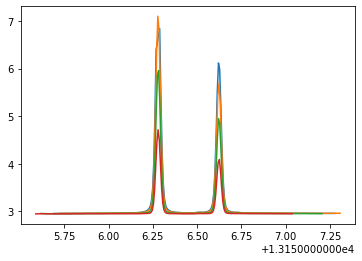

In [9]:
#Plotting each data set separately (different colors)
fig, ax = plt.subplots()
for i in range(len(x)):
    ax.plot(x[i][:, 0], y[i])
plt.show()

# Setting up the line shape models

In this section we want to define the line shape model. This will be the mean function that we input to our Gaussian Process Regression model (more on that later).

First, we need to define a scale for the noise. All this does is help ensure that matrices we will invert during training of Gaussian Processes are well-conditioned. This will typically be the case if we make the variance of the data close to 1, which is why we will divide the data by `noise_scale` later.

In [10]:
#Define a noise scale to make training a little more robust
noise_scale = np.average([np.std(y[i][:10]) for i in range(len(y))])
print(noise_scale)

0.0008708101055790094


Below is the main event of this section: creating `LineShape` class instances to represent each line shape that goes into the model. For any given molecular species, there are multiple peaks in the absorbance spectrum, all with different shapes. Each `LineShape` object represents one of these peaks, which corresponds to one line in the MATS Parameters_LineList.csv file. Only some of these lines will have parameters eligible for fitting, with this based on the value of the line intensity paramater (`sw`), which in MATS is scaled by a factor that defines whether or not the line shape should have freely-adjustable parameters (i.e., `sw` must be above this factor, or its scaled value above 1, as indicated below in the inequality to define a `fittable` boolean).

Going through all of the parameters and their meanings is beyond the scope of this documentation. Most important, however, are the values of `nu`, which is the peak location and `sw` which is the peak intensity. Passing `limit_factor_dict` defines how these, or other, parameters should be constrained. For instance ('factor', 2.0) means that the value read from the csv file should be constrained between half its value and twice its value. Passing ('magnitude', 0.1) just means that the parameter is between the read value plus/minus 0.1. `line_kwargs` defines keyword arguments that will be used when initializing a `LineShape` object - note that we're calling a parsing function `lineshape_from_dataframe` to generate `LineShape` instances from a pandas dataframe. The first notable argument is `dset_list` - this is the list of `SpectralDataInfo` objects we created earlier and will be shared across all lineshapes so they all use the correct dataset-specific parameters. Next is `linemix` which defines the `LineMix` object for the lineshape. Technically, the line mixing parameter `y` can not only change with nominal temperature, but also be different across line shapes, so we have to create a new `LineMix` object for each line in the dataframe. The `cutoff` parameter describes how far away from the peak center we stop simulating and the `noise_scale_factor` just scales the data so that matrix inversion is well-behaved in Gaussian Process Regression.

There is an important point to keep in mind about the inputs and parameters of `LineShape` objects. It is expected that the input has one row per data point, with the columns being the wavenumber, temperature, pressure, and dataset index. I have already mentioned that the last column is necessary for correctly obtaining dataset specific parameters, or even line mixing parameters (dataset provides nominal temperature, which maps to line mixing parameter). However, there are some parameters, such as `sw`, that commonly are allowed to also have a dataset dependence (i.e., we have a different value for each dataset). To accomplish this behavior, the parameters in `LineShape` can either be single valued or arrays of the same length as number of data sets. There is a function internal to `LineShape` that maps data set indexes to the appropriate parameter, simply selecting the same parameter for all indices provided if that parameter is not intended to vary with dataset. In the MATS parameter csv files, you can tell when a parameter varies with dataset because it will be labelled sw_1, sw_2, sw_3, etc.

In [11]:
lineparam_list = pd.read_csv('Parameter_LineList.csv', index_col=0)

line_list = []
for i, line in lineparam_list.iterrows():
    line_list.append(MATSgp.lineshape_from_dataframe(line,
                                              limit_factor_dict={'SD_gamma_air':('factor', 2.0),
                                                                 'nu':('magnitude', 0.1),
                                                                 'sw':('factor', 2.0)},
                                              line_kwargs={'dset_list':data_info_list,
                                                           'linemix':MATSgp.linemix_from_dataframe(line,
                                                                linemix_kwargs={'fittable':(line['sw'] >= 1.0)}),
                                                           'cutoff':25,
                                                           'noise_scale_factor':noise_scale,
                                                           'fittable':(line['sw'] >= 1.0)},
                                             )
                    )

2021-08-26 15:58:28.491253: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In addition to line shapes, the models in MATS also include etalons, which are sine function behaviors of spectra that occur due to resonant reflections of light within the optical cavity of the instrument. These are simple and have 4 parameters: amplitude (`amp`), period (`period`), phase (`phase`), and offset (`ref_wave`). The first three are self-explanatory for a sine function, while the last is just defining where "zero" is (i.e., we subtract `ref_wave` from the input before). Typically this is not adjustable because it is defined by the minimum wavenumber passed into a dataset. And because I said dataset, you guessed it, there is a separate etalon, or sine function, fit for each dataset. As in line shape, this is indicated by the parameters being vectors with the same shape as the number of data sets, with the appropriate parameter value for a data point indexed by the dataset indices passed as part of the input (the last column after wavenumber, temperature, and pressure).

In [12]:
#And etalons
etalons = MATSgp.Etalon([0.00165, 0.00165, 0.00165, 0.00165], #Hard-coding values from a MATS fit because have not written csv parser yet
                 [1.271443, 1.271443, 1.271443, 1.271443],
                 [-0.734156, -0.480252, -1.417825, -1.647160],
                 [np.min(xdat[:, 0]) for xdat in x],
                 noise_scale_factor=noise_scale,
                 dset_list=data_info_list,
                 fittable=True)

#To make certain parameters fittable, we need to set them this way with gpflow
#By default, I keep everything non-fittable when generating the classes
#Don't have to to this for LineShape because I have the nifty parser to set things the same as MATS has them
for param in ['amp', 'period', 'phase']:
    gpflow.set_trainable(etalons.params[param], True)


Finally also have baseline functions as part of the model. Here I have followed MATS and only implemented up to 2nd order polynomials. In the example below, we restrict this to only linear fits by setting the squared-term coefficient to zero and only allow the c0 and c1 terms to be fit.

In [13]:
#And baselines, too!
baselines = MATSgp.Baseline([2.958, 2.959, 2.953, 2.950], #Again hard-coding because need parser
                     [0.002031, 0.001985, 0.001964, 0.001776],
                     [0.0, 0.0, 0.0, 0.0],
                     [np.min(xdat[:, 0]) for xdat in x],
                     noise_scale_factor=noise_scale,
                     dset_list=data_info_list,
                     fittable=True)
for param in ['c0', 'c1']:
    gpflow.set_trainable(baselines.params[param], True)


To accumulate all of the line shapes, etalons, and baselines into a single callable function, I have implemented a convenience class called `ComboMeanFunc`, which just takes a list of functions satisfying gpflow's definition of a mean function.

In [14]:
#Put it all together in the combined mean function for the model
mean_func = MATSgp.ComboMeanFunc(line_list+[ #lineshape1, lineshape10, lineshape13, lineshape25, lineshape26,
                          etalons, #etalon1, etalon2, etalon3, etalon4,
                          baselines
                          ]
                         )

In [15]:
mean_func

name,class,transform,prior,trainable,shape,dtype,value
ComboMeanFunc.mean_funcs[1].linemix.y['296.0'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['nu'],Parameter,SoftClip,,False,"(4,)",float64,"[13154.18, 13154.18, 13154.18..."
ComboMeanFunc.mean_funcs[1].params['sw'],Parameter,SoftClip,,False,"(4,)",float64,"[4.369, 4.369, 4.369..."
ComboMeanFunc.mean_funcs[1].params['gamma0'],Parameter,Identity,,False,(),float64,0.04
ComboMeanFunc.mean_funcs[1].params['delta0'],Parameter,Identity,,False,(),float64,-0.007977
ComboMeanFunc.mean_funcs[1].params['sd_gamma'],Parameter,SoftClip,,False,(),float64,0.09999999999999999
ComboMeanFunc.mean_funcs[1].params['sd_delta'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['nuvc'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['eta'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['n_gamma0'],Parameter,Identity,,False,(),float64,0.8


The above conveniently prints out information on the function. All of the fittable parameters are listed with whether they are currently set to fittable in the "trainable" column. Most things are self-explanatory, but it's worth noting that the "transform" column indicates if there are any constraints, such as positivity, etc. "SoftClip" just means that we are "constraining" the parameter with a soft-clip function within a certain interval defined by the `limit_factor_dict` described earlier.

## Fitting without Gaussian Processes

In this section, we demonstrate how to peform vanilla least-squares fitting with our gpflow- and tensorflow-compatible model. To starte, we just define a callable that will define our squared residual.

In [16]:
#Define class object which, when called, provides mean squared residual
class least_squares_obj(object):
    def __init__(self, x_data, y_data, fit_func):
        self.x = x_data
        self.y = y_data
        self.f = fit_func
    
    def __call__(self):
        f_vals = self.f(self.x)
        res_sq = tf.square(f_vals - self.y)
        return tf.reduce_mean(res_sq)


In [17]:
#Set up data and objective
objective = least_squares_obj(np.vstack(x), np.hstack(y)[:, None]/noise_scale, mean_func)

#And see what its current value is
objective()

<tf.Tensor: shape=(), dtype=float64, numpy=0.9795520994286937>

Minimizing the objective is straight-forward. The gpflow.optimizers.Scipy() optimizer is just a wrapper on the scipy optimizer.

In [18]:
%%time
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(objective, mean_func.trainable_variables, options=dict(maxiter=500))

2021-08-26 16:01:44.476946: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 3min 11s, sys: 25.4 s, total: 3min 36s
Wall time: 2min 31s


In [19]:
#Check out the documentation for gpflow.optimizers.Scipy
#It's essentially just a wrapper around scipy optimizers (can specify which one with method='L-BFGS-B', etc.)
#But it calculates all the gradients with tensorflow
opt_logs

      fun: 0.7325597344709228
 hess_inv: <40x40 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.06916220e+00, -3.72267521e-01, -1.88173966e-01, -6.30143478e-02,
       -9.85817734e-01, -9.98964215e-03, -1.74342753e-01, -1.93944916e-02,
       -6.71813328e-02, -1.07965608e-03,  6.32319453e-01,  7.68852210e-04,
        4.25610335e-03,  8.35833598e-01,  7.41309813e-01, -3.68462712e-02,
        4.81150546e-01,  2.55796032e-01,  2.53363404e-01, -4.49056978e-03,
       -5.51462578e-04,  2.40526971e-02, -1.41543646e+00,  1.51244202e+00,
       -2.83690981e-01,  4.70037527e-01, -3.35222141e-01, -3.02839502e-01,
       -1.61010462e-01, -6.10243016e-02, -6.74154464e-02, -1.01496213e-01,
        8.76996645e-01, -4.03789424e-01,  1.40765039e-01, -9.24053516e-02,
       -7.43994183e-02,  6.20266878e-01,  7.29857781e-01,  5.90295641e-01])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 522
      nit: 500
     njev: 522
   status: 1
  success: False
        x: array([

In [20]:
#Can get the gradients from opt_logs.jac (see above)
#Or can manually compute - makes easy to evaluate ANY new objective we want and get gradients
#Oh, GradientTape! How great, thou art! The knees of the bees doth not compare! All that jazz encomposes not a tenth of thine virtue!
with tf.GradientTape() as tape:
    loss = objective()

grads = tape.gradient(loss, mean_func.trainable_variables)
print(grads)

(<tf.Tensor: shape=(), dtype=float64, numpy=1.0691622024430742>, <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-0.37226752, -0.18817397, -0.06301435, -0.98581773])>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.00998964215040362>, <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-0.17434275, -0.01939449, -0.06718133, -0.00107966])>, <tf.Tensor: shape=(), dtype=float64, numpy=0.6323194532592318>, <tf.Tensor: shape=(4,), dtype=float64, numpy=array([7.68852230e-04, 4.25610352e-03, 8.35833598e-01, 7.41309813e-01])>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.03684627118174176>, <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 0.48115055,  0.25579603,  0.2533634 , -0.00449057])>, <tensorflow.python.framework.indexed_slices.IndexedSlices object at 0x7f9c295d53d0>, <tensorflow.python.framework.indexed_slices.IndexedSlices object at 0x7f9c6c8757c0>, <tensorflow.python.framework.indexed_slices.IndexedSlices object at 0x7f9c295c84c0>, <tensorflow.python.framework.indexed_slices.

In [21]:
#The ordering for gradients is in accord with mean_func.trainable_variables...
mean_func.trainable_variables

(<tf.Variable 'gamma0:0' shape=() dtype=float64, numpy=0.04486331028604886>,
 <tf.Variable 'nu:0' shape=(4,) dtype=float64, numpy=array([13156.58901768, 13156.58906915, 13156.58941263, 13156.58817119])>,
 <tf.Variable 'sd_gamma:0' shape=() dtype=float64, numpy=-0.25929068960434437>,
 <tf.Variable 'sw:0' shape=(4,) dtype=float64, numpy=array([4.63802623, 4.65817552, 4.64873456, 4.71090293])>,
 <tf.Variable 'gamma0:0' shape=() dtype=float64, numpy=0.04353639873646497>,
 <tf.Variable 'nu:0' shape=(4,) dtype=float64, numpy=array([13156.99259437, 13156.99212056, 13156.99231317, 13156.99142186])>,
 <tf.Variable 'sd_gamma:0' shape=() dtype=float64, numpy=-0.20274195225759092>,
 <tf.Variable 'sw:0' shape=(4,) dtype=float64, numpy=array([2.89153567, 2.8959075 , 2.90131983, 2.93143161])>,
 <tf.Variable 'amp:0' shape=(4,) dtype=float64, numpy=array([0.00166606, 0.00190554, 0.00145048, 0.00158892])>,
 <tf.Variable 'period:0' shape=(4,) dtype=float64, numpy=array([1.20504884, 1.24310944, 1.23501838

In [22]:
mean_func

name,class,transform,prior,trainable,shape,dtype,value
ComboMeanFunc.mean_funcs[1].linemix.y['296.0'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['nu'],Parameter,SoftClip,,False,"(4,)",float64,"[13154.18, 13154.18, 13154.18..."
ComboMeanFunc.mean_funcs[1].params['sw'],Parameter,SoftClip,,False,"(4,)",float64,"[4.369, 4.369, 4.369..."
ComboMeanFunc.mean_funcs[1].params['gamma0'],Parameter,Identity,,False,(),float64,0.04
ComboMeanFunc.mean_funcs[1].params['delta0'],Parameter,Identity,,False,(),float64,-0.007977
ComboMeanFunc.mean_funcs[1].params['sd_gamma'],Parameter,SoftClip,,False,(),float64,0.09999999999999999
ComboMeanFunc.mean_funcs[1].params['sd_delta'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['nuvc'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['eta'],Parameter,Identity,,False,(),float64,0.0
ComboMeanFunc.mean_funcs[1].params['n_gamma0'],Parameter,Identity,,False,(),float64,0.8


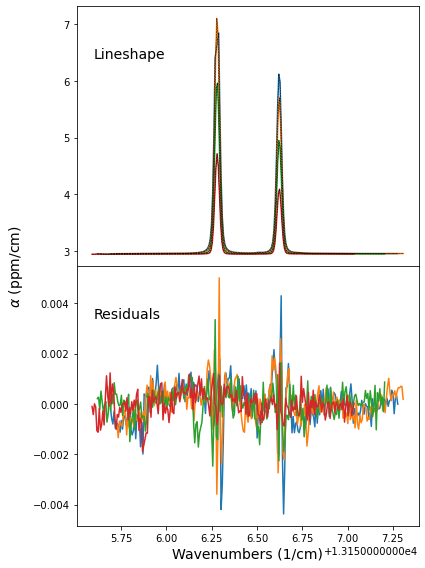

In [23]:
#%matplotlib notebook

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(2, sharex=True, sharey=False, figsize=(6, 8))

for i in range(len(x)):
    line = noise_scale * mean_func(x[i]).numpy().flatten()
    ax[0].plot(x[i][:, 0], line, color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--', linewidth=0.5, zorder=3)
    ax[1].plot(x[i][:, 0], line - y[i], color=colors[i])

ax[0].set_ylabel(r'$\alpha$ (ppm/cm)', fontsize=14)
ax[0].yaxis.set_label_coords(-0.15, 0.0)
ax[-1].set_xlabel(r'Wavenumbers (1/cm)', fontsize=14)
ax[0].annotate('Lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[1].annotate('Residuals', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()

## Fitting with Gaussian Processes

The goal of adding a Gaussian Process to our model is to better understand the uncertainty and simultaneously gain a function to predict the residuals of the fit. Typically in Gaussian Process Regression, it is assumed that the function you are modeling has a mean of zero. Clearly, you can relax this assumption by subtracting any function you want and just fitting the residual with a Gaussian Process. A note on this - even with this assumption, it does not mean that the model produced by fitting your data with a GPR will have zero mean. This is due to the covariance kernel, which effectively uses input data as part of the model (this is true for all regression to some extent). If the input data is not zero, the model will tend to pass through that data instead of zero because it is assumed implicitly through the covariance kernel that the function is similar in value near the provided data. So all that happens inside gpflow with the mean function is that it subtracts it from the data, performs GPR on the residual, then adds it back to the output at the end.

The extent that the model passes through the data exactly depends on its estimation of the uncertainty in the data. Sometimes this can be provided and allowed to vary with every data point (that's what I do with heteroscedastic likelihoods when using GPRs on molecular simulation data). Other times, we can let there be different uncertainties for different sets of data, which would be where the "switched" likelihoods come into play. Here, I have gone with the simplest option of assuming the the uncertainty is the **same** for all data points, with this value being the likelihood's variance, which is treated as a fittable parameter. That is not to say that this is an exact representation of our uncertainty when we provide an model prediction... The predicted uncertainty, or the variance in the response variable at a specified independent variable input, is a combination of the likelihood variance and the variance associated with the covariance kernel, so effectively how far the input point is from data points used for fitting. If the input is exactly at an input data point, the uncertainty is the likelihood variance because (for most kernels) there will not be a contribution for distances of zero.

In [24]:
#Create gpflow model
gpflow.config.set_default_jitter(1e-06)

test_x = np.vstack(x)
#Add column in y to indicate different likelihoods, i.e., different noise on different experimental datasets
test_y = np.vstack([np.vstack([y[i], np.ones_like(y[i])*i]).T for i in range(len(y))])
print(test_x.shape)
print(test_y.shape)

#Noise variance is around 1e-6 or 1e-07, which is an issue for GPflow
#To avoid numerical problems, scale output by noise standard deviation so noise variance will be order 1
test_y[:, 0] /= noise_scale

#Specify kernel that ignores the dimension specifying just the dataset index
kern = gpflow.kernels.SquaredExponential(lengthscales=1.0*(np.amax(test_x[:, :-1], axis=0)
                                                           - np.amin(test_x[:, :-1], axis=0)),
                                         active_dims=[0, 1, 2]) #Tells the kernel to only use dimensions 0, 1, 2 of input, i.e., wavenumber, tempearature, and pressure

#Define our Gaussian process regression model
# gpr = SwitchedGPR(data=(test_x, test_y),
#                   kernel=kern,
#                   mean_function=mean_func,
#                   noise_variance=[1.0]*len(y))

#To save computation time, can also try with sparse GP model using inducing points
#These inducing points effectively represent the data to save computation
induce_pts = gpflow.inducing_variables.InducingPoints(np.vstack([xdat[np.random.choice(xdat.shape[0], size=10, replace=False)]
                                                                 for xdat in x]))
gpr = gpflow.models.SGPR(data=(test_x, test_y[:, :1]), #Have not implemented switched likelihood with sparse GPR yet
                         kernel=kern,
                         inducing_variable=induce_pts,
                         mean_function=mean_func,
                         noise_variance=1.0,
                         num_latent_gps=1)

#Can even go to sparse variational GP to get access to likelihood
#But maybe don't... becomes very slow to train and if have lots of datasets, likely to get awkward
#In a sense, a single noise variance still captures idea that some datasets may be less reliable...
#If only because will predict higher uncertainty at conditions (T and P) of that dataset
# gpr = gpflow.models.SVGP(kernel=kern,
#                          likelihood=gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.Gaussian(variance=1.0) for i in range(len(x))]),
#                          inducing_variable=induce_pts,
#                          mean_function=mean_func,
#                          num_latent_gps=1)

(928, 4)
(928, 2)


In [25]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
SGPR.mean_function.mean_funcs[1].linemix.y['296.0'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['nu'],Parameter,SoftClip,,False,"(4,)",float64,"[13154.18, 13154.18, 13154.18..."
SGPR.mean_function.mean_funcs[1].params['sw'],Parameter,SoftClip,,False,"(4,)",float64,"[4.369, 4.369, 4.369..."
SGPR.mean_function.mean_funcs[1].params['gamma0'],Parameter,Identity,,False,(),float64,0.04
SGPR.mean_function.mean_funcs[1].params['delta0'],Parameter,Identity,,False,(),float64,-0.007977
SGPR.mean_function.mean_funcs[1].params['sd_gamma'],Parameter,SoftClip,,False,(),float64,0.09999999999999999
SGPR.mean_function.mean_funcs[1].params['sd_delta'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['nuvc'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['eta'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['n_gamma0'],Parameter,Identity,,False,(),float64,0.8


Notice that by adding the GP model, we have only added 4 new parameters (some are multidimensional, so more than that technically, but only 4 new lines in the above output).

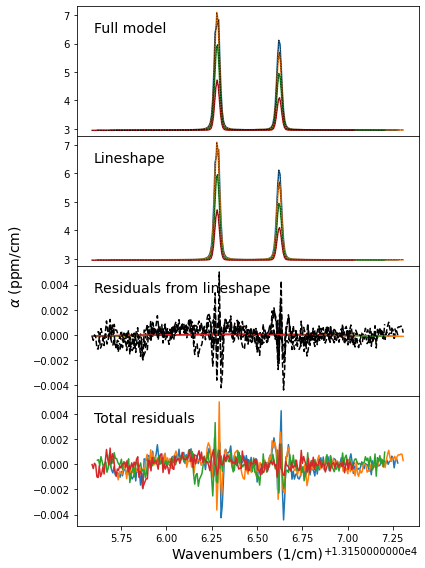

In [26]:
#%matplotlib notebook

#Predictions before training
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(4, sharex=True, sharey=False, figsize=(6, 8))

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    mean = noise_scale * mean[:, 0].numpy()
    var = (noise_scale**2) * var[:, 0].numpy()
    line = noise_scale * gpr.mean_function(x[i]).numpy().flatten()
    ax[0].errorbar(x[i][:, 0], mean, yerr=np.sqrt(var), color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--', linewidth=0.5, zorder=3)
    ax[1].plot(x[i][:, 0], line, color=colors[i])
    ax[1].plot(x[i][:, 0], y[i] - (mean - line), 'k--', linewidth=0.5)
    ax[2].plot(x[i][:, 0], line - mean, color=colors[i])
    ax[2].plot(x[i][:, 0], line - y[i], 'k--')
    ax[3].plot(x[i][:, 0], mean - y[i], color=colors[i])

ax[1].set_ylabel(r'$\alpha$ (ppm/cm)', fontsize=14)
ax[1].yaxis.set_label_coords(-0.15, 0.0)
ax[-1].set_xlabel(r'Wavenumbers (1/cm)', fontsize=14)
ax[0].annotate('Full model', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[1].annotate('Lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[2].annotate('Residuals from lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[3].annotate('Total residuals', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()

In the above, the first panel is the full model, mean function plus GP output. The second is just the mean function. The third is the residuals between the data and mean function (line shape model) plotted together with the GP output, which to start out should essentially just be all zeros if the initial value for the likelihood variance is much larger than the values of the residuals. In the final panel I show the total residuals, so the full mean function plus GP output minus the data.

When I say residuals, I actually just mean the subtraction of the data from the model. In non-linear least squares regression, the squared residuals represent the loss function. This is equivalent to assuming a Gaussian Process model with likelihood variance that is fixed to a value of 1 and a covariance kernel that is just a delta function so that there are no correlations between data points. The full GP model will be a multivariate Gaussian with the covariance matrix specified by the chosen kernel (and the data used for fitting) and the mean function the one you defined, so it will have a similar structure, but with different effective weighting on the data points based on how close to other data points they are and how quickly they cause the function to change (and how consistent that is with other data points used in the fit).

We can fit again with the same procedure, but now we will also minimize the GP model parameters and will be using the full likelihood, not the least-squares objective.

In [27]:
%%time

#Note that optimizing with a Gaussian Process changes the objective function
#This means that the parameter values found with least-squares for the lineshape model may not be the same
#So we could freeze the lineshape model parameters and only optimize the GP model accounting for everything else...
#That would be fine for just estimating how the residuals and overall uncertainties vary with conditions
#But it's a little inconsistent with the overall model including the GP, so here we optimize everything

#You could also easily argue that optimizing both the model parameters and GP together is already inconsistent
#It is if you want reasonable priors; here, the priors on the lineshape parameters are delta functions
#That way, the likelihood has a closed-form solution (the GP parameter priors can be integrated out)
#Otherwise, you'd need MCMC to figure out the best parameters

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=500))

CPU times: user 3min 18s, sys: 26 s, total: 3min 44s
Wall time: 2min 33s


In [28]:
opt_logs

      fun: 1188.1662381692245
 hess_inv: <205x205 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.34733352e-03, -1.47735703e-02, -3.53996706e-02,  0.00000000e+00,
       -9.45742673e-04, -2.11648543e-02, -2.76267603e-02,  0.00000000e+00,
        5.97785070e-03,  4.23864286e-02, -8.75206927e-03,  0.00000000e+00,
        4.50122079e-03,  2.87563331e-02, -4.43985694e-03,  0.00000000e+00,
        1.90075632e-04, -2.36878043e-03,  3.77138423e-03,  0.00000000e+00,
        8.89349433e-05,  1.10667788e-02,  3.42151367e-03,  0.00000000e+00,
        8.75313254e-04,  2.17703859e-03,  2.87072050e-03,  0.00000000e+00,
       -3.24334175e-04,  7.28791975e-03,  7.99095269e-03,  0.00000000e+00,
        1.69885956e-02, -5.45617629e-04, -1.14906820e-01,  0.00000000e+00,
        7.43446634e-04, -1.14778213e-02, -1.43806727e-02,  0.00000000e+00,
       -6.40628475e-04, -4.29604357e-03,  1.63538343e-02,  0.00000000e+00,
        5.36384142e-03,  4.25632863e-02, -8.83608175e-02,  0.00000000e+00,

In [29]:
#This and the next cell are only if you use a stochastic variational Gaussian Process (SVGP)
#This can be safely ignored, but was left in case we want to explore that more in the future.

# tensor_data = tuple(map(tf.convert_to_tensor, (test_x, test_y)))

# svgp_loss =  gpr.training_loss_closure(tensor_data, compile=True)

# gpflow.set_trainable(gpr.q_mu, False)
# gpflow.set_trainable(gpr.q_sqrt, False)

In [30]:
# %%time

# natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=1.0)
# adam_opt = tf.optimizers.Adam(0.01)

# for _ in range(100):
#     #svgp_loss = gpr.training_loss_closure(next(data_minibatch_it))
#     natgrad_opt.minimize(svgp_loss, var_list=[(gpr.q_mu, gpr.q_sqrt)])
#     adam_opt.minimize(svgp_loss, var_list=gpr.trainable_variables)
# 
# #Takes about 12 minutes with SVGP

If we want the line shape model to be fixed, we can just fix those parameters and it will only fit the GP model. This is equivalent to just taking the residuals from a fit with MATS and passing those as the input for a Gaussian process. Note, though, that in that case we use a least-squares objective to get the line shape model parameters, and a different objective for the GP model. There is no gaurantee that the optimal line shape parameters will be the same for the two objectives, though we expect them to be close in practice. The "right way," then, is to always fit with the full objective based on Gaussian Processes, as above, though this may not always be computationally tractable.

In [31]:
#Assuming lineshape model makes up most of loss, now freeze those parameters...
for param in gpr.mean_function.trainable_parameters:
    gpflow.set_trainable(param, False)

In [32]:
%%time

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=500))

CPU times: user 2min 9s, sys: 9.9 s, total: 2min 19s
Wall time: 1min 48s


In [33]:
opt_logs

      fun: 1131.7256793511447
 hess_inv: <165x165 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.58405486e-02,  1.24209660e-01, -2.19394379e-03,  0.00000000e+00,
       -1.68065218e-01, -4.37748233e-02,  1.11439077e-02,  0.00000000e+00,
        5.86182556e-07, -3.86991430e-06,  1.88584735e-08,  0.00000000e+00,
        1.46854043e-02, -1.64097084e-01, -1.13022949e-03,  0.00000000e+00,
       -5.91340689e-02,  1.31595422e-01, -1.64276318e-02,  0.00000000e+00,
        1.18174926e-01, -2.75625493e-02, -1.20302435e-02,  0.00000000e+00,
       -1.82236474e-08,  6.47936832e-08, -2.71415398e-10,  0.00000000e+00,
        1.08986242e-01,  7.83684354e-02,  1.56677662e-02,  0.00000000e+00,
        9.95570545e-02,  1.60154845e-02, -2.24084910e-02,  0.00000000e+00,
        6.09045119e-02, -3.70271741e-03, -1.75964192e-02,  0.00000000e+00,
       -1.25106706e-12,  5.94233587e-12,  5.87347109e-14,  0.00000000e+00,
       -8.65724835e-08,  4.18506724e-06,  7.26527614e-08,  0.00000000e+00,

In [34]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
SGPR.mean_function.mean_funcs[1].linemix.y['296.0'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['nu'],Parameter,SoftClip,,False,"(4,)",float64,"[13154.18, 13154.18, 13154.18..."
SGPR.mean_function.mean_funcs[1].params['sw'],Parameter,SoftClip,,False,"(4,)",float64,"[4.369, 4.369, 4.369..."
SGPR.mean_function.mean_funcs[1].params['gamma0'],Parameter,Identity,,False,(),float64,0.04
SGPR.mean_function.mean_funcs[1].params['delta0'],Parameter,Identity,,False,(),float64,-0.007977
SGPR.mean_function.mean_funcs[1].params['sd_gamma'],Parameter,SoftClip,,False,(),float64,0.09999999999999999
SGPR.mean_function.mean_funcs[1].params['sd_delta'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['nuvc'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['eta'],Parameter,Identity,,False,(),float64,0.0
SGPR.mean_function.mean_funcs[1].params['n_gamma0'],Parameter,Identity,,False,(),float64,0.8


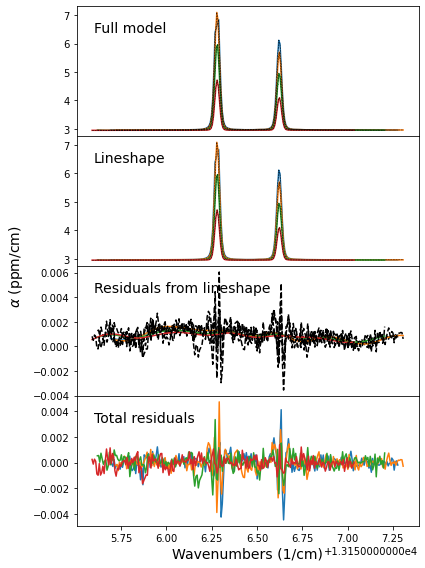

In [35]:
#Predictions after training
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(4, sharex=True, sharey=False, figsize=(6, 8))

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    mean = noise_scale * mean[:, 0].numpy()
    var = (noise_scale**2) * var[:, 0].numpy()
    line = noise_scale * gpr.mean_function(x[i]).numpy().flatten()
    ax[0].errorbar(x[i][:, 0], mean, yerr=np.sqrt(var), color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--', linewidth=0.5, zorder=3)
    ax[1].plot(x[i][:, 0], line, color=colors[i])
    ax[1].plot(x[i][:, 0], y[i] - (mean - line), 'k--', linewidth=0.5)
    ax[2].plot(x[i][:, 0], line - mean, color=colors[i])
    ax[2].plot(x[i][:, 0], line - y[i], 'k--')
    ax[3].plot(x[i][:, 0], mean - y[i], color=colors[i])

ax[1].set_ylabel(r'$\alpha$ (ppm/cm)', fontsize=14)
ax[1].yaxis.set_label_coords(-0.15, 0.0)
ax[-1].set_xlabel(r'Wavenumbers (1/cm)', fontsize=14)
ax[0].annotate('Full model', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[1].annotate('Lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[2].annotate('Residuals from lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[3].annotate('Total residuals', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()

Now we are in a position to make some predictions on how the uncertainty predicted by the GP model (so the full combination of the likelihood variance and output of the covariance kernel) changes with various conditions.

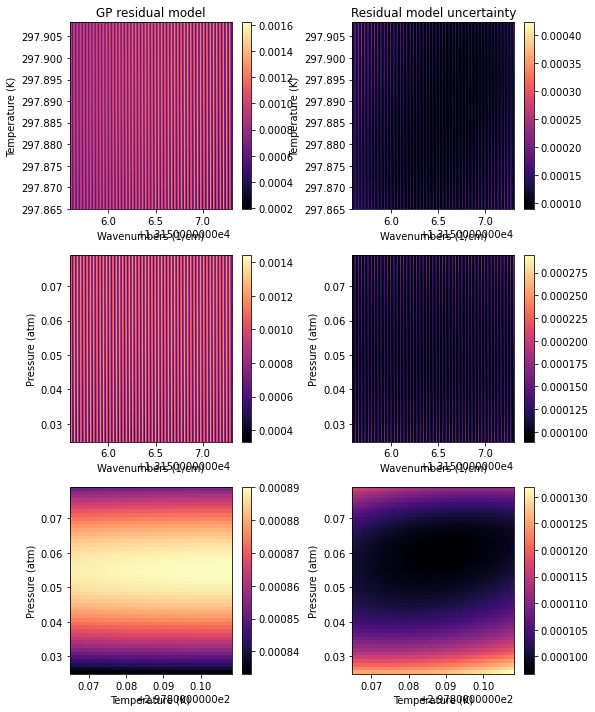

In [36]:
#Look at uncertainty as a function of wavenumber, temperature, pressure
x_vals = np.linspace(np.min(test_x[:, 0]), np.max(test_x[:, 0]), 500)
t_vals = np.linspace(np.min(test_x[:, 1]), np.max(test_x[:, 1]), 50)
p_vals = np.linspace(np.min(test_x[:, 2]), np.max(test_x[:, 2]), 50)

xt_grid = np.vstack([a.flatten() for a in np.meshgrid(x_vals, t_vals)]).T
xt_grid = np.hstack([xt_grid, np.average(p_vals)*np.ones((xt_grid.shape[0], 1))])
xp_grid = np.vstack([a.flatten() for a in np.meshgrid(x_vals, p_vals)]).T
xp_grid = np.vstack([xp_grid[:, 0], np.average(t_vals)*np.ones(xp_grid.shape[0]), xp_grid[:, 1]]).T
tp_grid = np.vstack([a.flatten() for a in np.meshgrid(t_vals, p_vals)]).T
tp_grid = np.hstack([np.average(x_vals)*np.ones((tp_grid.shape[0], 1)), tp_grid])

#Use likelihood for first dataset
xt_grid = np.hstack([xt_grid, np.zeros((xt_grid.shape[0], 1))])
xp_grid = np.hstack([xp_grid, np.zeros((xp_grid.shape[0], 1))])
tp_grid = np.hstack([tp_grid, np.zeros((tp_grid.shape[0], 1))])

fig, ax = plt.subplots(3, 2, figsize=(8, 10))

ax_labels = [('Wavenumbers (1/cm)', 'Temperature (K)'),
             ('Wavenumbers (1/cm)', 'Pressure (atm)'),
             ('Temperature (K)', 'Pressure (atm)')]

shapes = [(500, 50), (500, 50), (50, 50)]

extents = [(xt_grid[0, 0], xt_grid[-1, 0], xt_grid[0, 1], xt_grid[-1, 1]),
           (xp_grid[0, 0], xp_grid[-1, 0], xp_grid[0, 2], xp_grid[-1, 2]),
           (tp_grid[0, 1], tp_grid[-1, 1], tp_grid[0, 2], tp_grid[-1, 2])]

for i, grid in enumerate([xt_grid, xp_grid, tp_grid]):
    mean, var = gpr.predict_f(grid)
    res = noise_scale * (gpr.mean_function(grid) - mean)
    res = np.reshape(res, shapes[i])
    std = noise_scale * np.sqrt(var[:, 0])
    std = np.reshape(std, shapes[i])
    im_res = ax[i, 0].imshow(res.T, cmap='magma', aspect='auto', origin='lower', extent=extents[i])
    im_std = ax[i, 1].imshow(std.T, cmap='magma', aspect='auto', origin='lower', extent=extents[i])
    plt.colorbar(im_res, ax=ax[i, 0])
    plt.colorbar(im_std, ax=ax[i, 1])
    for j in range(2):
        ax[i, j].set_xlabel(ax_labels[i][0])
        ax[i, j].set_ylabel(ax_labels[i][1])

ax[0, 0].set_title('GP residual model')
ax[0, 1].set_title('Residual model uncertainty')
fig.tight_layout()
plt.show()

In the above figures, I have created a grid of input points across many wavenumbers, temperatures, and pressures. In each figure, we are fixing one dimension and taking a slice to look at variations across the other two. The most interesting to us would be the last, something where we look at the predicted uncertainty as a function of temperature and pressure. For this I have chosen just one wavenumber and I am plotting the predicted standard deviation from the GP model. To get a sense of a "total" uncertainty over all wavenumbers, you want want to integrate the predicted variance function over that dimension - at least this is the only way I am aware of to get a sense of the overall uncertainty.

Now in what's below, we can calculate derivatives of whatever comes out of our model. So if we wanted the derivative of the predicted variance at a specific wavenumber, temperature, and pressure (or the integral of this over all wavenumbers at a specific temperature and pressure) with respect to a parameter of interest, we could just calculate that inside GradientTape and the ask what the derivative is. Below, I do this for the predicted residual. So this would be along the lines of "What is the sensitivity of the model residual to a given parameter at a specific wavenumber, temperature, and pressure?" I would expect that points where the residual responds strongly to a parameter are points where data accumulation could be most beneficial. We can play the same game with the predicted uncertainty, but in that case, we are not asking where to collect data to get the fit better (reduced residuals), but instead where is the best point to reduce the estimated uncertainty? This wouldn't necessarily require taking a derivative - I'm not actually sure what the interpretation of that derivative would be. Remember, the uncertainty at some points may be higher than others due to the covariance kernel. So the model is predicting where we have high uncertainty and that is also where we would want to run new experiments if we are interested in increasing our confidence in the model (of course, this is solely using the fit Gaussian Process to estimate uncertainty!).

In [37]:
#Now lets say we want to know how the sensitivity of the residual at a specific condition to our a parameter
#So using the GP residual model at that wavenumber, T, and P as the "objective" and get gradients...

gpflow.set_trainable(gpr.mean_function.mean_funcs[10].params['gamma0'], True) #Must be trainable!

test_point = np.array([np.average(test_x, axis=0)])
test_point[:, -1] = 0 #Have to set data set index... technically part of model input

with tf.GradientTape() as tape:
    mean, var = gpr.predict_f(test_point)
    res = noise_scale * (gpr.mean_function(test_point) - mean)

tape.gradient(res, [gpr.mean_function.variables[17]]) #17 is gamma0 for line 10... can work on better way to locate/index

[<tf.Tensor: shape=(), dtype=float64, numpy=0.05643452253413296>]

## MCMC with GPflow and tensorflow-probability